In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from model_pvp import model_pvp
from make_prob_matrix import make_prob_matrix
from get_prob_matrix import get_prob_matrix
from scipy.stats import anderson_ksamp

In [2]:
# Read data from xlsx file

games = pd.read_excel('../Results.xlsx', sheet_name='Games')
turns = pd.read_excel('../Results.xlsx', sheet_name='Turns')
pve_games = games.query('GameState == "END" and (idPerson1 == 10 or idPerson2 == 10)'
                        ' and (idPerson1 not in [30, 203, 217]'
                        ' and idPerson2 not in [30, 203, 217])')
player_border_games = pve_games.query('idPerson1 == 10')
player_center_games = pve_games.query('idPerson2 == 10')
player_border_games_ids = player_border_games['idGame']
player_center_games_ids = player_center_games['idGame']

In [3]:
# Put data into arrays

player_border_turns = []
player_border_states = []
player_center_turns = []
player_center_states = []

player_center_choices = []
player_border_games_turns_timestamps = []
player_center_games_turns_timestamps = []

for i in player_border_games_ids:
    player_border_game_i_turns = turns.query('Games_idGame == ' + str(i))
    player_border_games_turns_timestamps.append(player_border_game_i_turns.sort_values(by='idTurn')['AddedTime'])
    for state in player_border_game_i_turns.sort_values(by='idTurn')['State']:
        player_border_states.append(state)
    player_border_turns.append(max(player_border_game_i_turns['idTurn']))

for i in player_center_games_ids:
    player_center_game_i_turns = turns.query('Games_idGame == ' + str(i))
    player_center_choices.append(player_center_game_i_turns.sort_values(by='idTurn')['Turn'])
    player_center_games_turns_timestamps.append(player_center_game_i_turns.sort_values(by='idTurn')['AddedTime'])
    for state in player_center_game_i_turns.sort_values(by='idTurn')['State']:
        player_center_states.append(state)
    player_center_turns.append(max(player_center_game_i_turns['idTurn']))

PvB

KS-тест

Оптимальное ε: 0.010


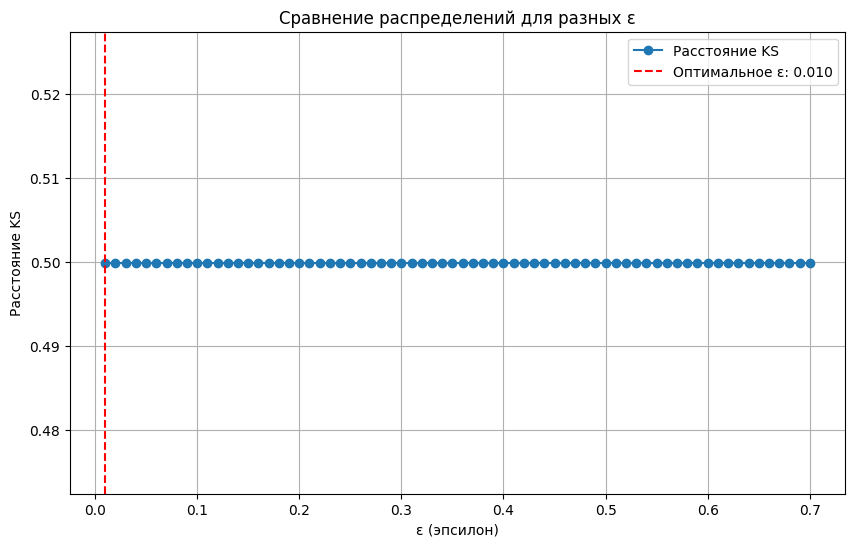

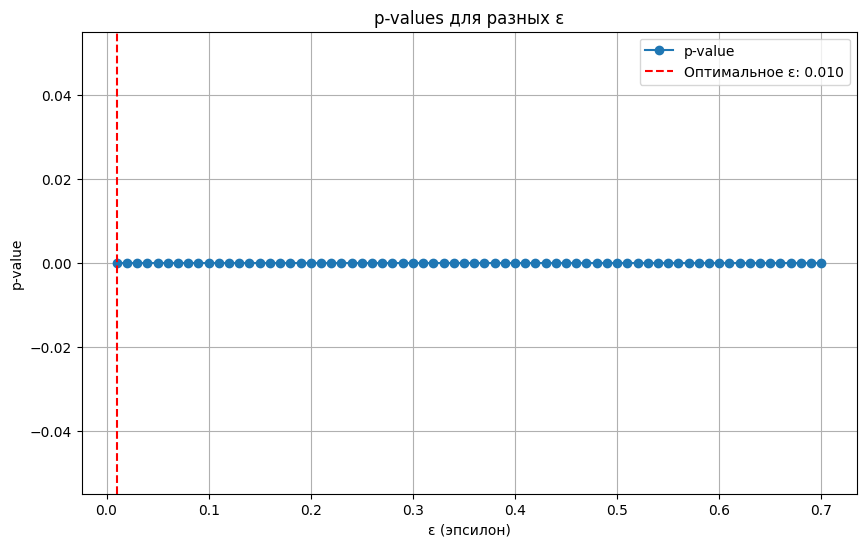

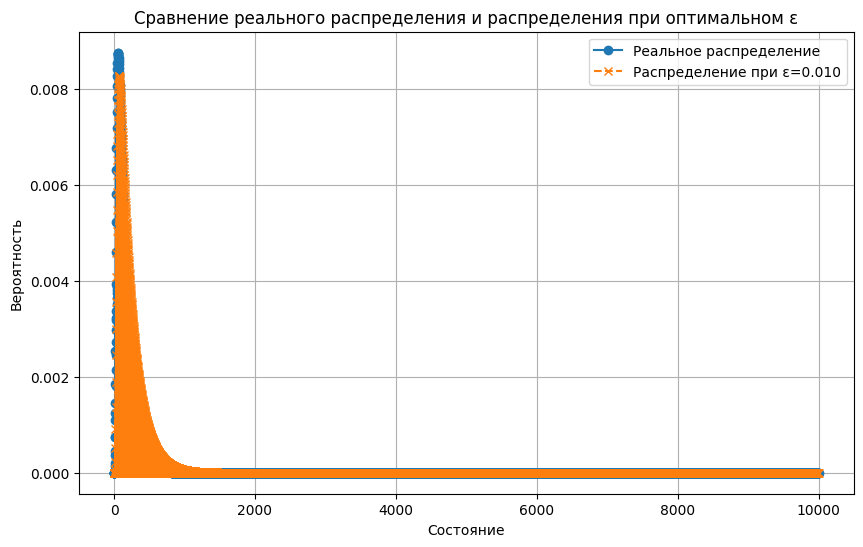

In [4]:
N = 16
epsilon_vals = np.arange(0.01, 0.71, 0.01)
qr_matrices = []
for eps in epsilon_vals:
    qr_matrix = np.load(f"..\\output\\eps_border\\pvb\\try_5\\qr\\qr_{eps:.2f}.npy")
    qr_matrices.append(qr_matrix)

pmf_epsilon = []
for qr in qr_matrices:
    _, prob, (_, _) = model_pvp(N, qr, num_steps=10000)
    pmf_epsilon.append(prob)

#real_qr_matrix = np.load("..\\data\\experiment_pve_center_pmf.npy")
#_, prob_real, (_, _) = model_pvp(N, real_qr_matrix, num_steps=10000)
qr_real_matrix, probability_matrix_center, counts_center = get_prob_matrix(N, player_center_states, return_counts=True)
_, prob_real, (_, _) = model_pvp(N, qr_real_matrix, num_steps=10000)
#prob_real = np.load("..\\data\\experiment_pve_center_pmf.npy")

p_values = []
ks_distances = []
for prob in pmf_epsilon:
    ks_stat, p_value = ks_2samp(prob_real, prob)
    ks_distances.append(ks_stat)
    p_values.append(p_value)

# Нахождение оптимального ε
optimal_epsilon = epsilon_vals[np.argmin(ks_distances)]
optimal_prob = pmf_epsilon[np.argmin(ks_distances)]

print(f"Оптимальное ε: {optimal_epsilon:.3f}")

# Построение графика расстояний
plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, ks_distances, marker='o', label='Расстояние KS')
plt.axvline(optimal_epsilon, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('Расстояние KS')
plt.title('Сравнение распределений для разных ε')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, p_values, marker='o', label='p-value')
plt.axvline(optimal_epsilon, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('p-values для разных ε')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(prob_real, label='Реальное распределение', linestyle='-', marker='o')
plt.plot(optimal_prob, label=f'Распределение при ε={optimal_epsilon:.3f}', linestyle='--', marker='x')
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε')
plt.legend()
plt.grid()
plt.show()

JSD-тест

In [5]:
from scipy.spatial.distance import jensenshannon

def bootstrap_jsd(prob_real, prob_model, n_bootstrap=1000):
    """
    Вычисляет p-value с использованием бутстреппинга для JSD.
    """
    jsd_observed = jensenshannon(prob_real, prob_model)
    jsd_bootstrap = []

    for _ in range(n_bootstrap):
        bootstrap_real = np.random.choice(prob_real, size=len(prob_real), replace=True)
        bootstrap_model = np.random.choice(prob_model, size=len(prob_model), replace=True)
        
        jsd_bootstrap.append(jensenshannon(bootstrap_real, bootstrap_model))

    p_value = np.mean(np.array(jsd_bootstrap) >= jsd_observed)
    return p_value

Оптимальное ε (JSD): 0.010


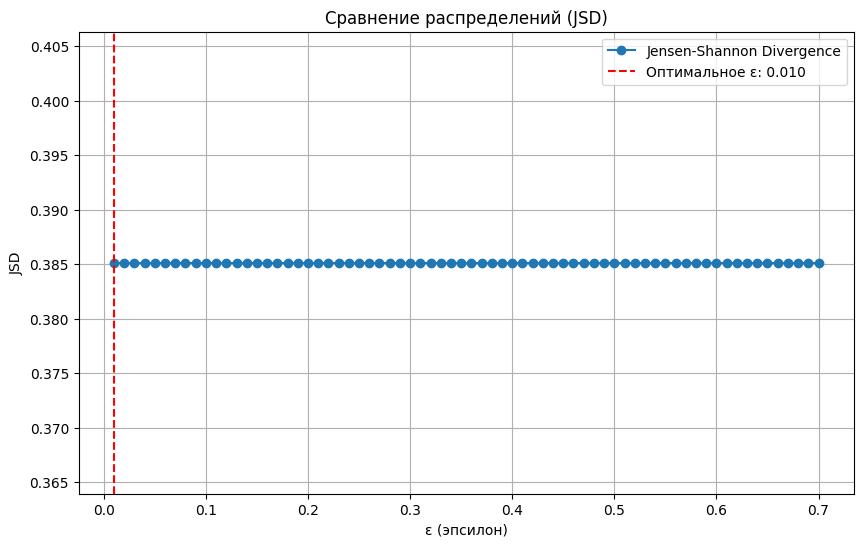

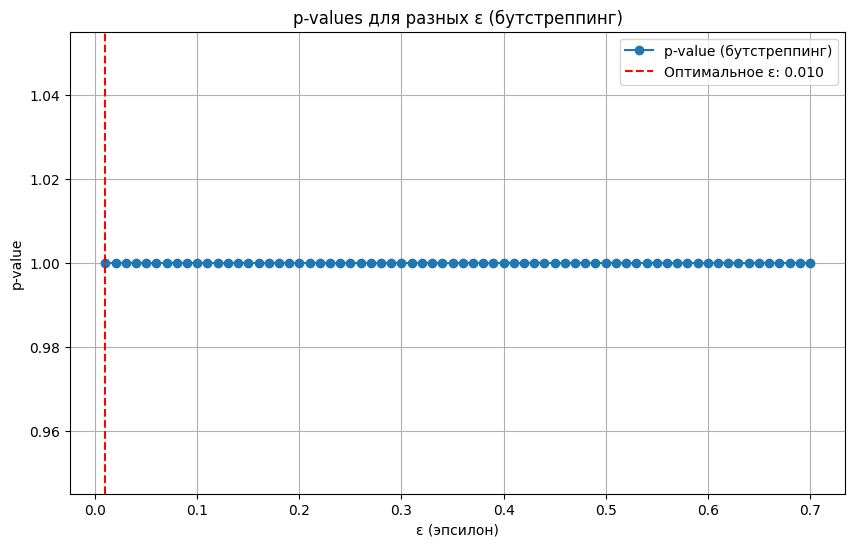

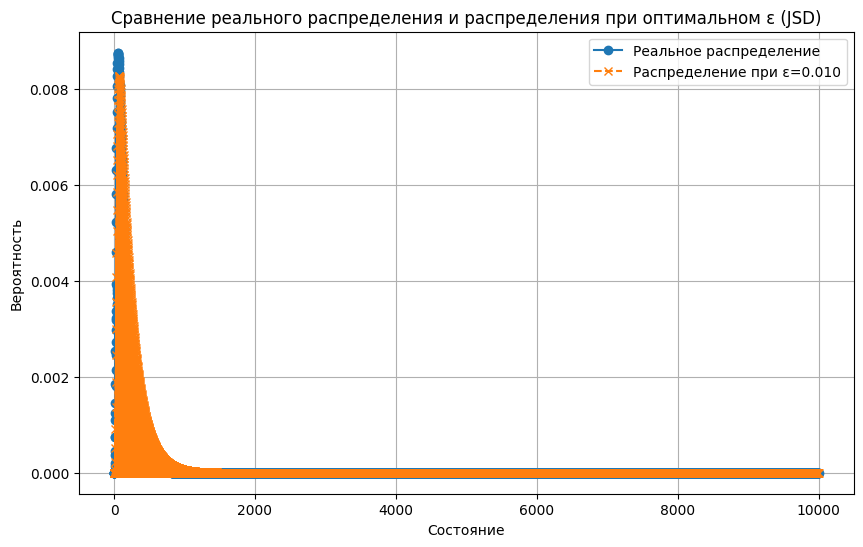

In [6]:
js_distances = []
p_values = []
for prob in pmf_epsilon:
    js_distance = jensenshannon(prob_real, prob)
    js_distances.append(js_distance)
    p_value = bootstrap_jsd(prob_real, prob)
    p_values.append(p_value)

optimal_epsilon_js = epsilon_vals[np.argmin(js_distances)]
optimal_prob_js = pmf_epsilon[np.argmin(js_distances)]
print(f"Оптимальное ε (JSD): {optimal_epsilon_js:.3f}")

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, js_distances, marker='o', label='Jensen-Shannon Divergence')
plt.axvline(optimal_epsilon_js, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_js:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('JSD')
plt.title('Сравнение распределений (JSD)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, p_values, marker='o', label='p-value (бутстреппинг)')
plt.axvline(optimal_epsilon_js, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_js:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('p-values для разных ε (бутстреппинг)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(prob_real, label='Реальное распределение', linestyle='-', marker='o')
plt.plot(optimal_prob_js, label=f'Распределение при ε={optimal_epsilon_js:.3f}', linestyle='--', marker='x')
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε (JSD)')
plt.legend()
plt.grid()
plt.show()

AD-тест

C:\Users\Илья\AppData\Local\Temp\ipykernel_8232\2036576675.py:3: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_stat, critical_values, p_value = anderson_ksamp([prob_real, prob])


Оптимальное ε: 0.010


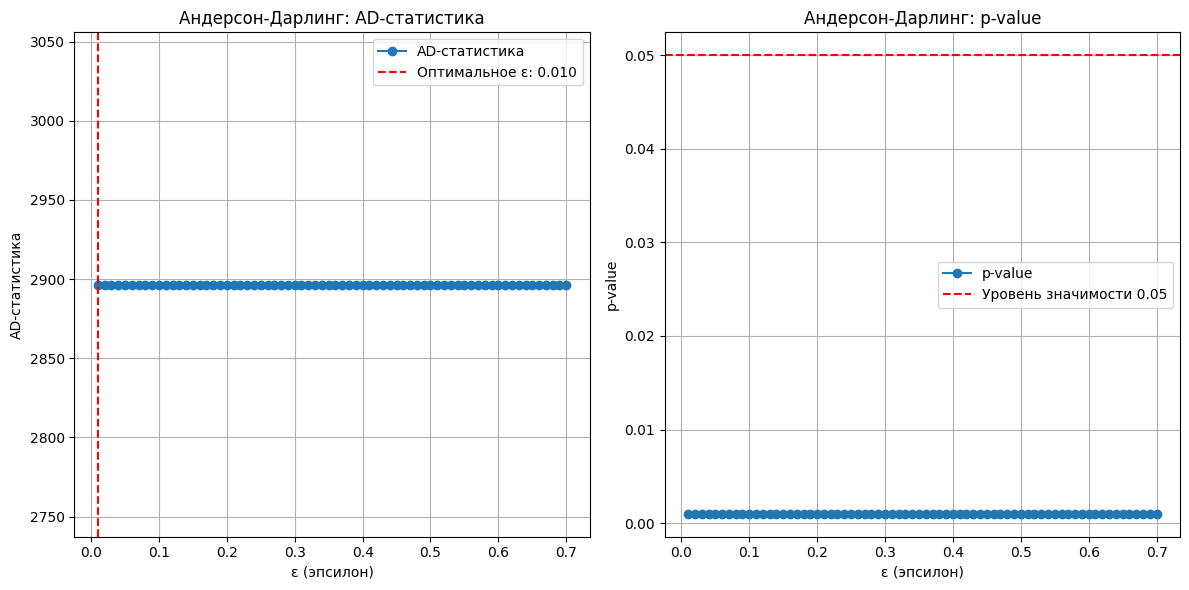

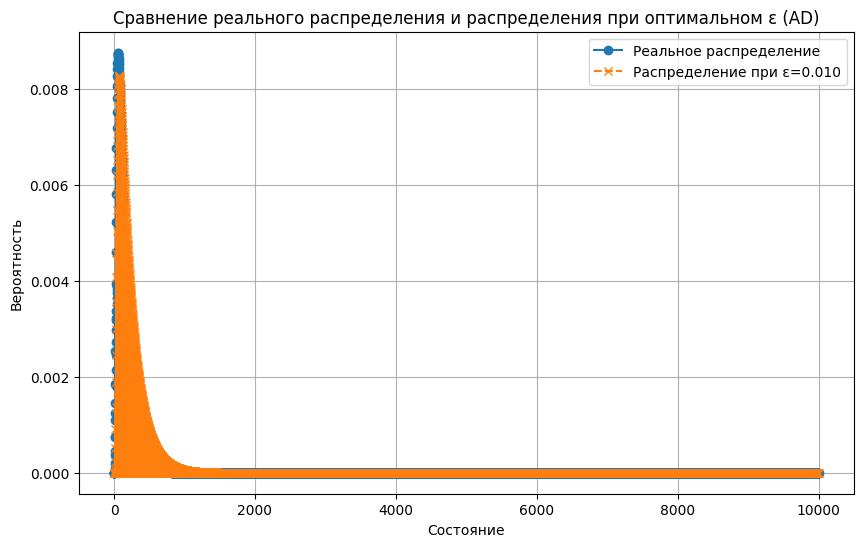

In [8]:
ad_results = []
for prob in pmf_epsilon:
    ad_stat, critical_values, p_value = anderson_ksamp([prob_real, prob])
    ad_results.append((ad_stat, p_value))

ad_stats = [res[0] for res in ad_results]
ad_p_values = [res[1] for res in ad_results]

optimal_epsilon_ad = epsilon_vals[np.argmin(ad_stats)]
optimal_prob_ad = pmf_epsilon[np.argmin(ad_stats)]

print(f"Оптимальное ε: {optimal_epsilon_ad:.3f}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epsilon_vals, ad_stats, marker='o', label='AD-статистика')
plt.axvline(optimal_epsilon_ad, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_ad:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('AD-статистика')
plt.title('Андерсон-Дарлинг: AD-статистика')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epsilon_vals, ad_p_values, marker='o', label='p-value')
plt.axhline(y=0.05, color='red', linestyle='--', label='Уровень значимости 0.05')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('Андерсон-Дарлинг: p-value')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(prob_real, label='Реальное распределение', linestyle='-', marker='o')
plt.plot(optimal_prob_ad, label=f'Распределение при ε={optimal_epsilon_ad:.3f}', linestyle='--', marker='x')
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε (AD)')
plt.legend()
plt.grid()
plt.show()

BvP

KS-тест

Оптимальное ε: 0.170


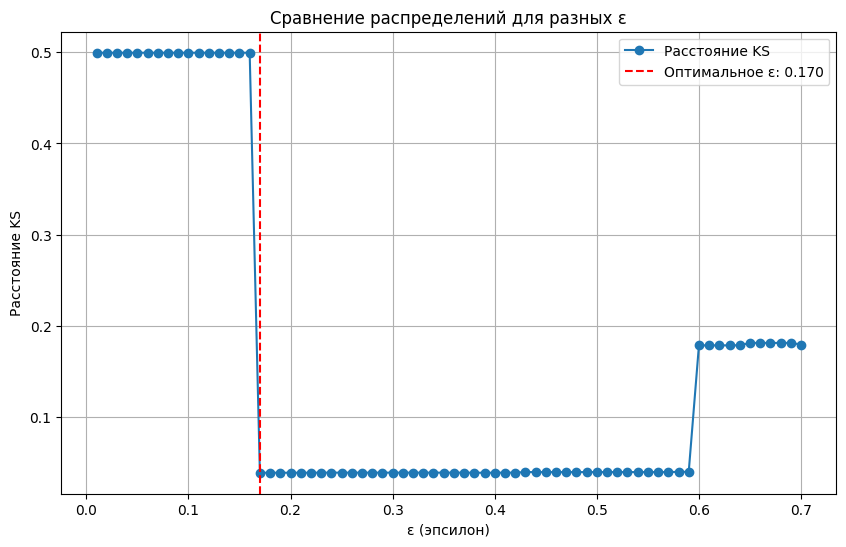

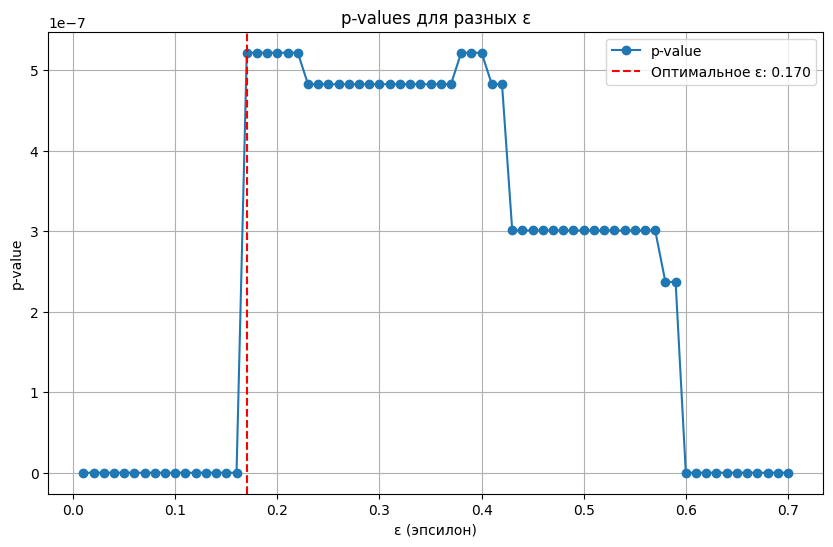

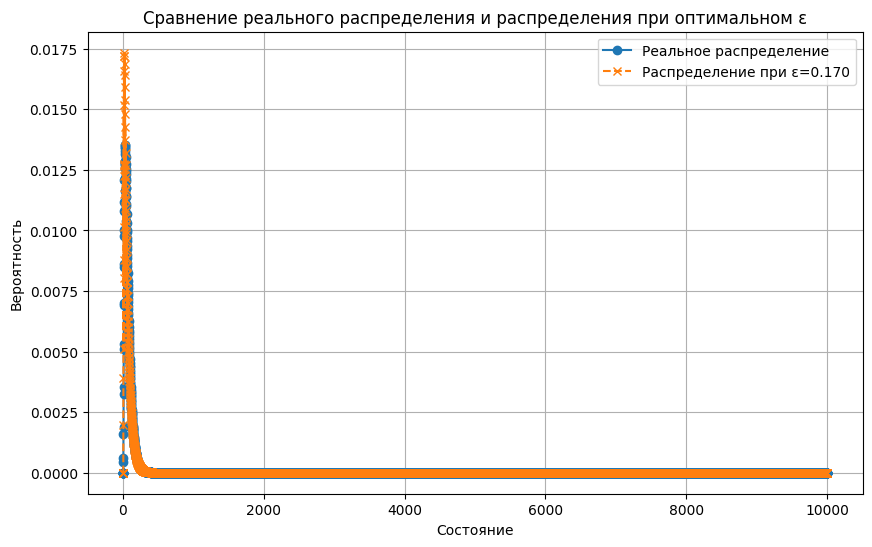

In [9]:
N = 16
epsilon_vals = np.arange(0.01, 0.71, 0.01)
qr_matrices = []
for eps in epsilon_vals:
    qr_matrix = np.load(f"..\\output\\eps_border\\bvp\\try_4\\qr\\qr_{eps:.2f}.npy")
    qr_matrices.append(qr_matrix)

pmf_epsilon = []
for qr in qr_matrices:
    _, prob, (_, _) = model_pvp(N, qr, num_steps=10000)
    pmf_epsilon.append(prob)

#real_qr_matrix = np.load("..\\data\\experiment_pve_center_pmf.npy")
#_, prob_real, (_, _) = model_pvp(N, real_qr_matrix, num_steps=10000)
#prob_real = np.load("..\\data\\experiment_pve_border_pmf.npy")

qr_real_matrix, probability_matrix_border, counts_border = get_prob_matrix(N, player_border_states, return_counts=True)
_, prob_real, (_, _) = model_pvp(N, qr_real_matrix, num_steps=10000)

p_values = []
ks_distances = []
for prob in pmf_epsilon:
    ks_stat, p_value = ks_2samp(prob_real, prob)
    ks_distances.append(ks_stat)
    p_values.append(p_value)

# Нахождение оптимального ε
optimal_epsilon = epsilon_vals[np.argmin(ks_distances)]
optimal_prob = pmf_epsilon[np.argmin(ks_distances)]

print(f"Оптимальное ε: {optimal_epsilon:.3f}")

# Построение графика расстояний
plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, ks_distances, marker='o', label='Расстояние KS')
plt.axvline(optimal_epsilon, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('Расстояние KS')
plt.title('Сравнение распределений для разных ε')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, p_values, marker='o', label='p-value')
plt.axvline(optimal_epsilon, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('p-values для разных ε')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(prob_real, label='Реальное распределение', linestyle='-', marker='o')
plt.plot(optimal_prob, label=f'Распределение при ε={optimal_epsilon:.3f}', linestyle='--', marker='x')
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε')
plt.legend()
plt.grid()
plt.show()

JSD-тест

Оптимальное ε (JSD): 0.260


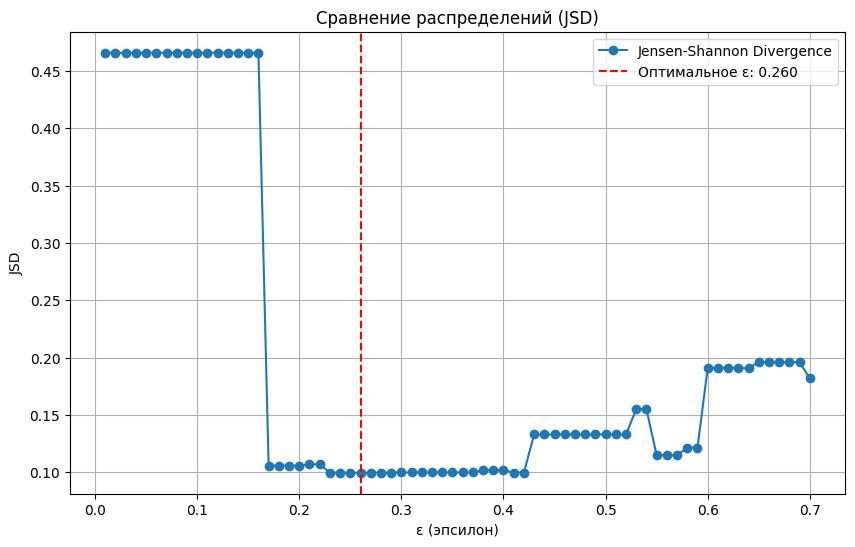

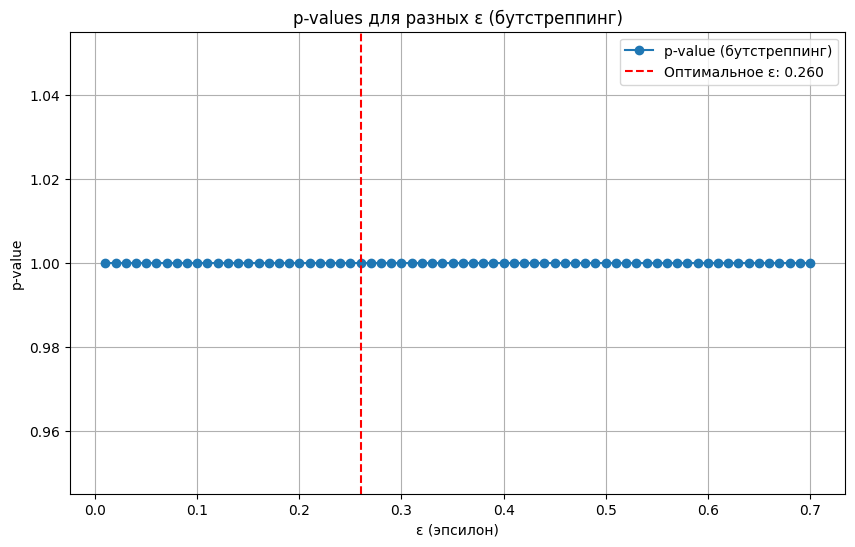

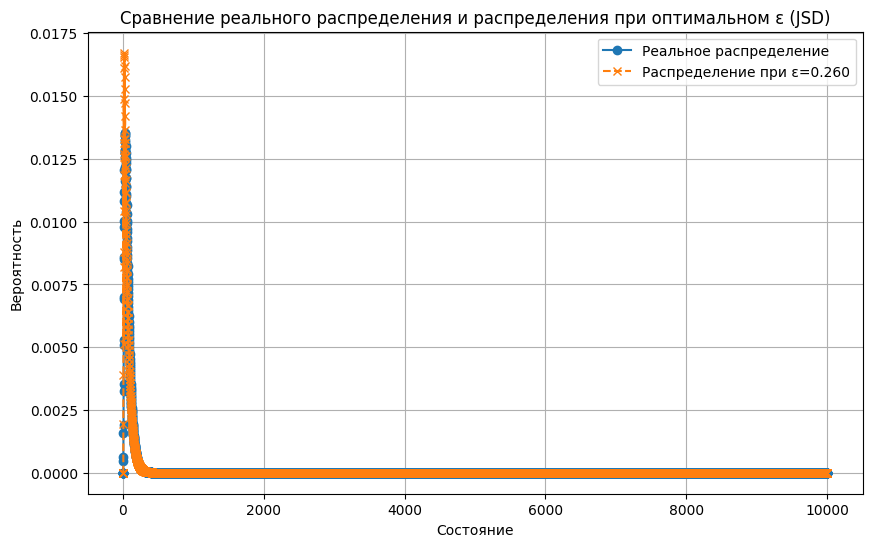

In [10]:
from scipy.spatial.distance import jensenshannon

js_distances = []
p_values = []
for prob in pmf_epsilon:
    js_distance = jensenshannon(prob_real, prob)
    js_distances.append(js_distance)
    p_value = bootstrap_jsd(prob_real, prob)
    p_values.append(p_value)

optimal_epsilon_js = epsilon_vals[np.argmin(js_distances)]
optimal_prob_js = pmf_epsilon[np.argmin(js_distances)]
print(f"Оптимальное ε (JSD): {optimal_epsilon_js:.3f}")

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, js_distances, marker='o', label='Jensen-Shannon Divergence')
plt.axvline(optimal_epsilon_js, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_js:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('JSD')
plt.title('Сравнение распределений (JSD)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, p_values, marker='o', label='p-value (бутстреппинг)')
plt.axvline(optimal_epsilon_js, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_js:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('p-values для разных ε (бутстреппинг)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(prob_real, label='Реальное распределение', linestyle='-', marker='o')
plt.plot(optimal_prob_js, label=f'Распределение при ε={optimal_epsilon_js:.3f}', linestyle='--', marker='x')
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε (JSD)')
plt.legend()
plt.grid()
plt.show()

AD-тест

C:\Users\Илья\AppData\Local\Temp\ipykernel_8232\2036576675.py:3: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_stat, critical_values, p_value = anderson_ksamp([prob_real, prob])


Оптимальное ε: 0.210


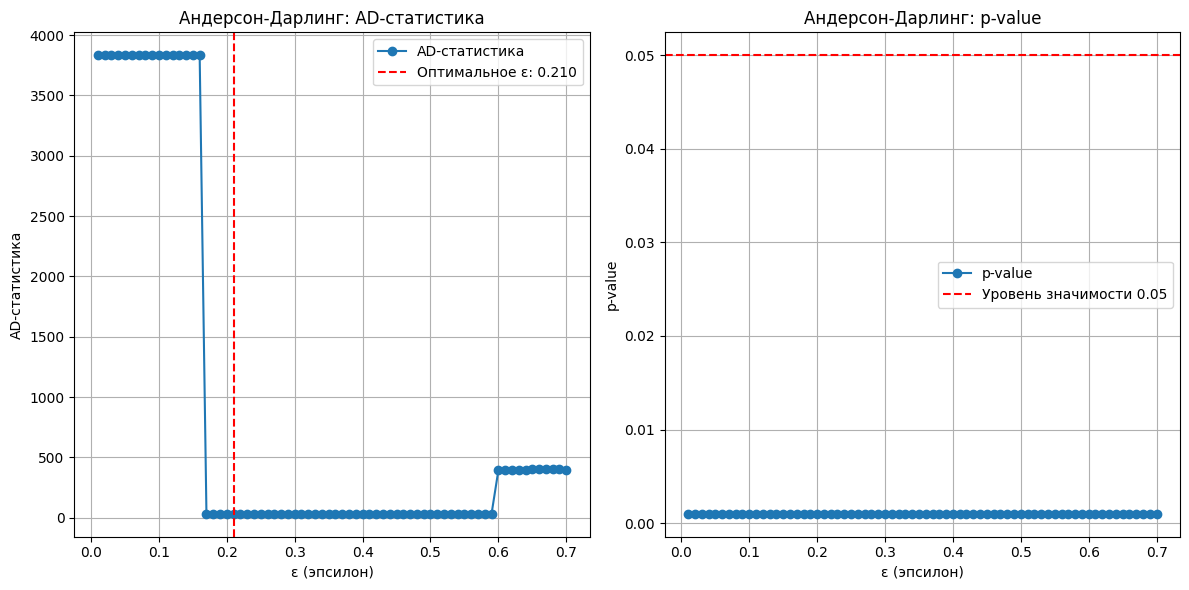

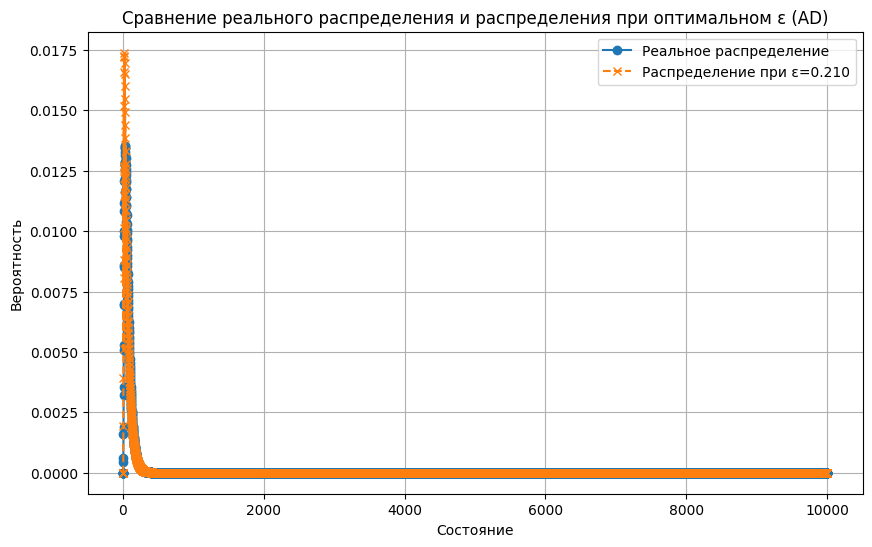

In [11]:
ad_results = []
for prob in pmf_epsilon:
    ad_stat, critical_values, p_value = anderson_ksamp([prob_real, prob])
    ad_results.append((ad_stat, p_value))

ad_stats = [res[0] for res in ad_results]
ad_p_values = [res[1] for res in ad_results]

optimal_epsilon_ad = epsilon_vals[np.argmin(ad_stats)]
optimal_prob_ad = pmf_epsilon[np.argmin(ad_stats)]

print(f"Оптимальное ε: {optimal_epsilon_ad:.3f}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epsilon_vals, ad_stats, marker='o', label='AD-статистика')
plt.axvline(optimal_epsilon_ad, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_ad:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('AD-статистика')
plt.title('Андерсон-Дарлинг: AD-статистика')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epsilon_vals, ad_p_values, marker='o', label='p-value')
plt.axhline(y=0.05, color='red', linestyle='--', label='Уровень значимости 0.05')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('Андерсон-Дарлинг: p-value')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(prob_real, label='Реальное распределение', linestyle='-', marker='o')
plt.plot(optimal_prob_ad, label=f'Распределение при ε={optimal_epsilon_ad:.3f}', linestyle='--', marker='x')
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε (AD)')
plt.legend()
plt.grid()
plt.show()

PVP

Сравнение с распределением границы

KS-тест

Оптимальное ε: 0.700


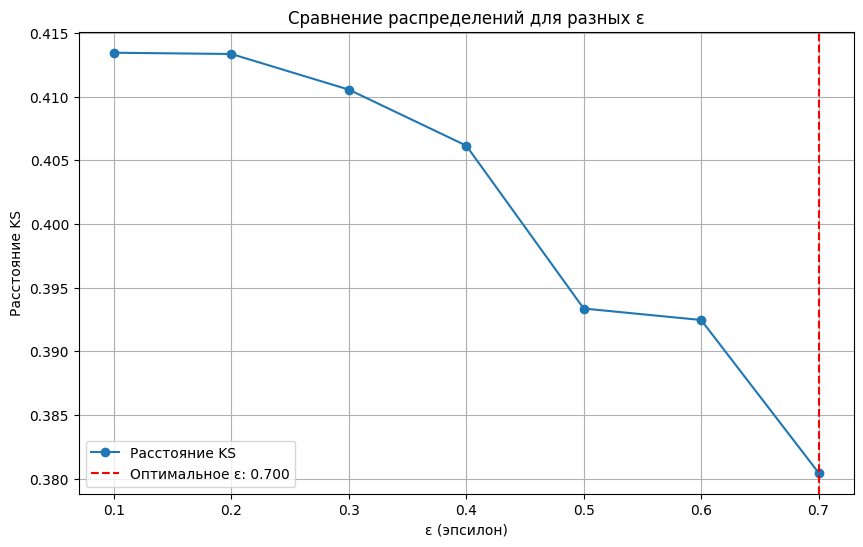

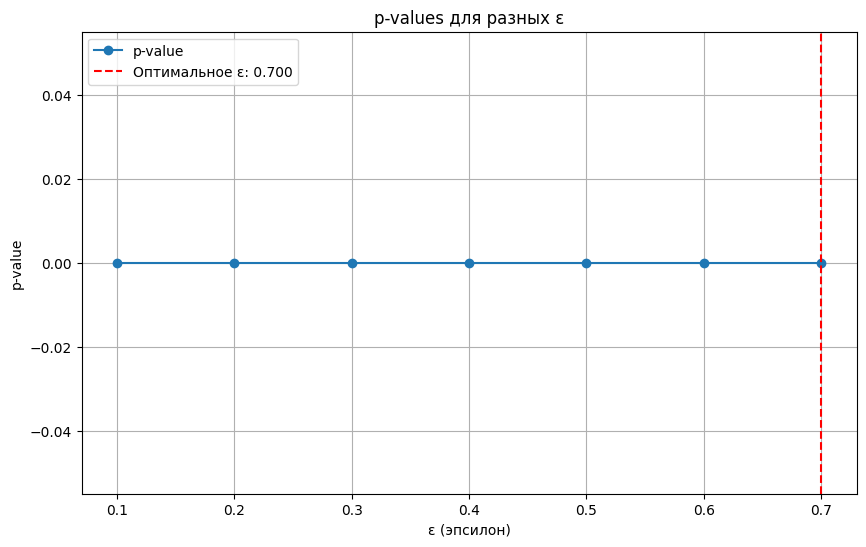

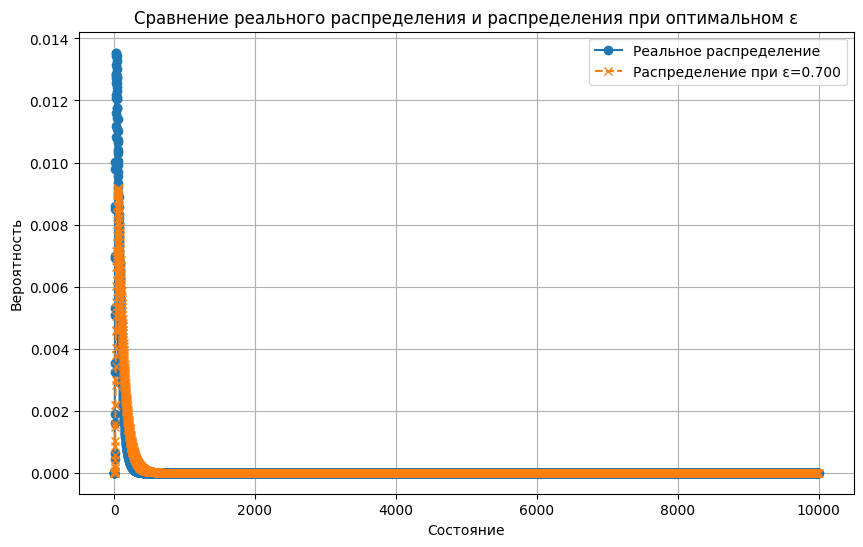

In [13]:
N = 16
epsilon_vals = np.arange(0.1, 0.8, 0.1)
qr_matrices = []
for eps in epsilon_vals:
    qr_matrix = np.load(f"..\\output\\eps_border\\pvp\\try_6\\qr\\qr_{eps:.2f}.npy")
    qr_matrices.append(qr_matrix)

pmf_epsilon = []
for qr in qr_matrices:
    _, prob, (_, _) = model_pvp(N, qr, num_steps=10000)
    pmf_epsilon.append(prob)

qr_real_matrix, probability_matrix_border, counts_border = get_prob_matrix(N, player_border_states, return_counts=True)
_, prob_real, (_, _) = model_pvp(N, qr_real_matrix, num_steps=10000)

p_values = []
ks_distances = []
for prob in pmf_epsilon:
    ks_stat, p_value = ks_2samp(prob_real, prob)
    ks_distances.append(ks_stat)
    p_values.append(p_value)

optimal_epsilon = epsilon_vals[np.argmin(ks_distances)]
optimal_prob = pmf_epsilon[np.argmin(ks_distances)]

print(f"Оптимальное ε: {optimal_epsilon:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, ks_distances, marker='o', label='Расстояние KS')
plt.axvline(optimal_epsilon, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('Расстояние KS')
plt.title('Сравнение распределений для разных ε')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, p_values, marker='o', label='p-value')
plt.axvline(optimal_epsilon, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('p-values для разных ε')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(prob_real, label='Реальное распределение', linestyle='-', marker='o')
plt.plot(optimal_prob, label=f'Распределение при ε={optimal_epsilon:.3f}', linestyle='--', marker='x')
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε')
plt.legend()
plt.grid()
plt.show()

JSD-тест

Оптимальное ε (JSD): 0.700


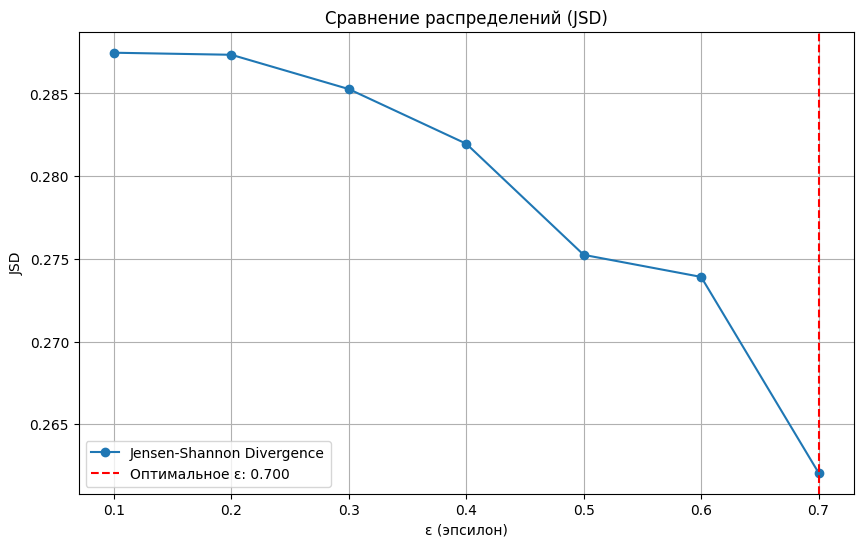

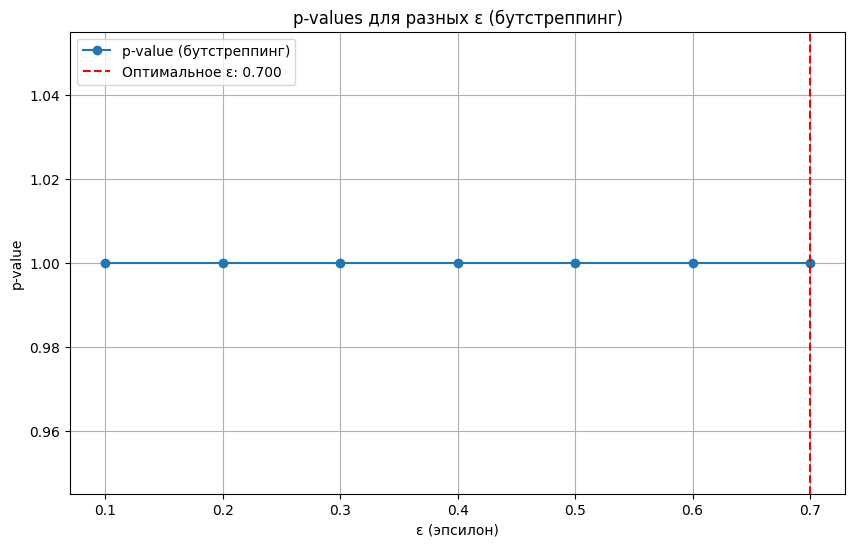

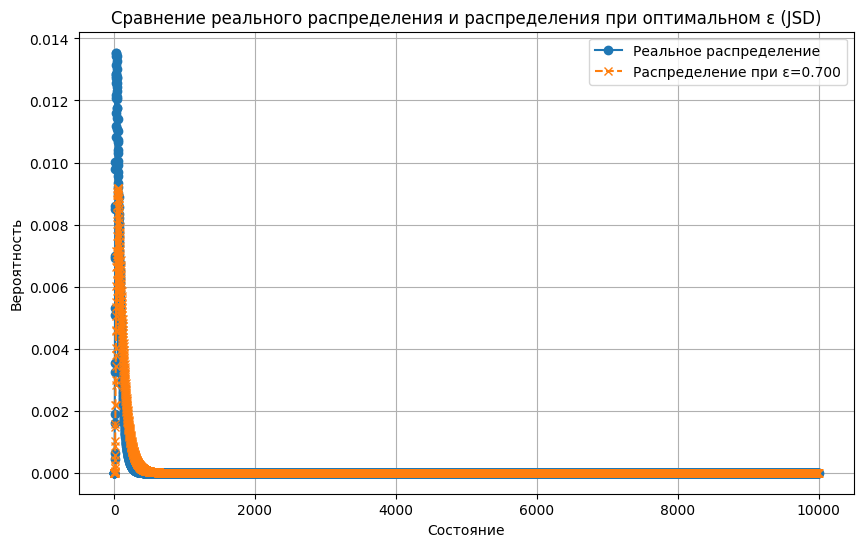

In [14]:
from scipy.spatial.distance import jensenshannon

js_distances = []
p_values = []
for prob in pmf_epsilon:
    js_distance = jensenshannon(prob_real, prob)
    js_distances.append(js_distance)
    p_value = bootstrap_jsd(prob_real, prob)
    p_values.append(p_value)

optimal_epsilon_js = epsilon_vals[np.argmin(js_distances)]
optimal_prob_js = pmf_epsilon[np.argmin(js_distances)]
print(f"Оптимальное ε (JSD): {optimal_epsilon_js:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, js_distances, marker='o', label='Jensen-Shannon Divergence')
plt.axvline(optimal_epsilon_js, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_js:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('JSD')
plt.title('Сравнение распределений (JSD)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, p_values, marker='o', label='p-value (бутстреппинг)')
plt.axvline(optimal_epsilon_js, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_js:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('p-values для разных ε (бутстреппинг)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(prob_real, label='Реальное распределение', linestyle='-', marker='o')
plt.plot(optimal_prob_js, label=f'Распределение при ε={optimal_epsilon_js:.3f}', linestyle='--', marker='x')
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε (JSD)')
plt.legend()
plt.grid()
plt.show()

AD-тест

C:\Users\Илья\AppData\Local\Temp\ipykernel_8232\2036576675.py:3: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_stat, critical_values, p_value = anderson_ksamp([prob_real, prob])


Оптимальное ε: 0.700


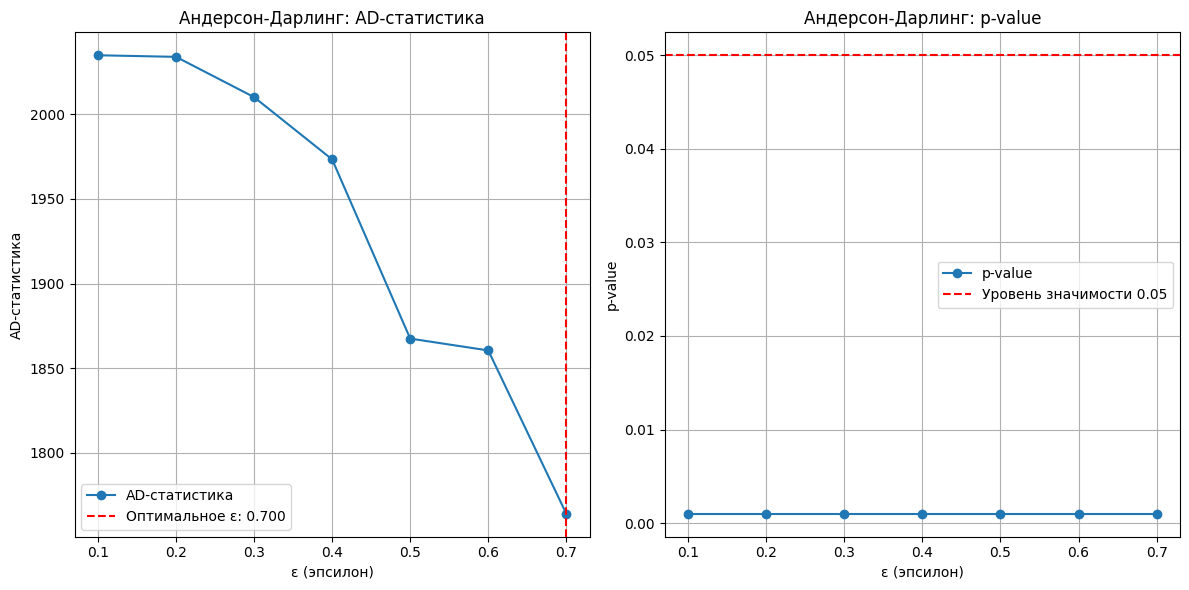

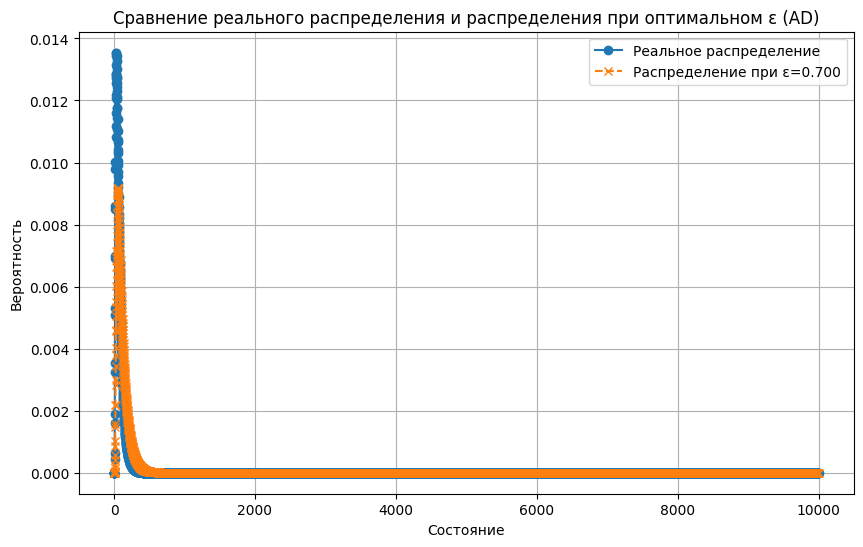

In [15]:
ad_results = []
for prob in pmf_epsilon:
    ad_stat, critical_values, p_value = anderson_ksamp([prob_real, prob])
    ad_results.append((ad_stat, p_value))

ad_stats = [res[0] for res in ad_results]
ad_p_values = [res[1] for res in ad_results]

optimal_epsilon_ad = epsilon_vals[np.argmin(ad_stats)]
optimal_prob_ad = pmf_epsilon[np.argmin(ad_stats)]

print(f"Оптимальное ε: {optimal_epsilon_ad:.3f}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epsilon_vals, ad_stats, marker='o', label='AD-статистика')
plt.axvline(optimal_epsilon_ad, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_ad:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('AD-статистика')
plt.title('Андерсон-Дарлинг: AD-статистика')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epsilon_vals, ad_p_values, marker='o', label='p-value')
plt.axhline(y=0.05, color='red', linestyle='--', label='Уровень значимости 0.05')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('Андерсон-Дарлинг: p-value')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(prob_real, label='Реальное распределение', linestyle='-', marker='o')
plt.plot(optimal_prob_ad, label=f'Распределение при ε={optimal_epsilon_ad:.3f}', linestyle='--', marker='x')
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε (AD)')
plt.legend()
plt.grid()
plt.show()

Сравнение с распределением центра

KS-тест

Оптимальное ε: 0.100


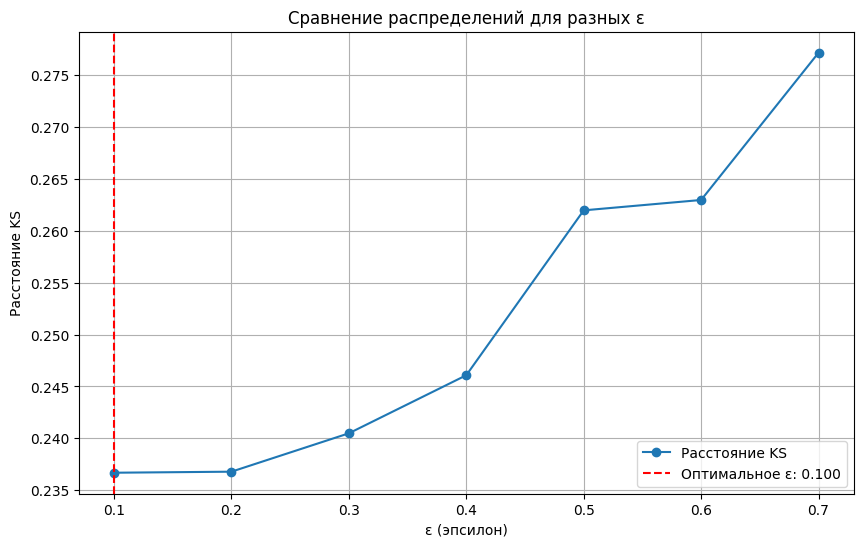

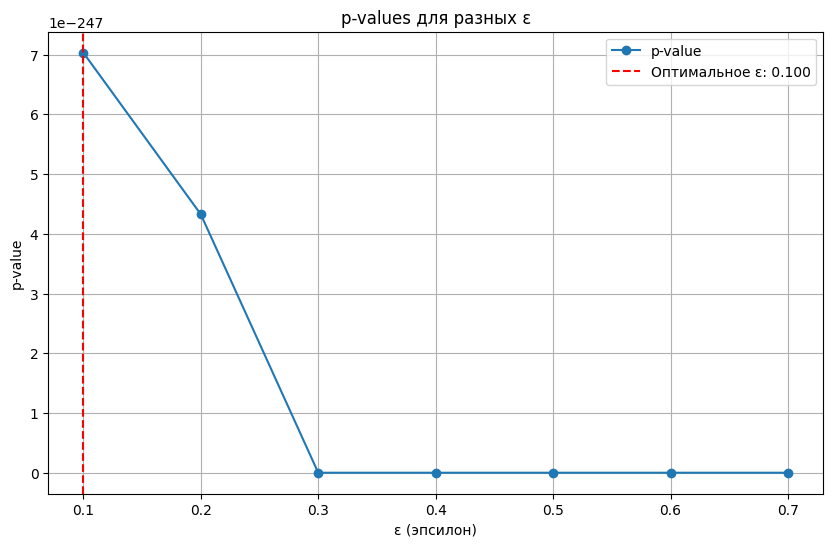

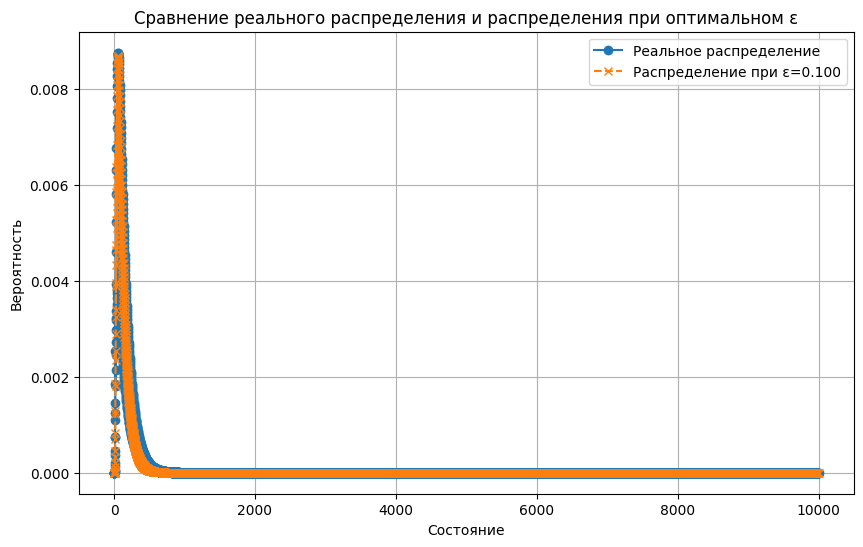

In [16]:
qr_real_matrix, probability_matrix_center, counts_center = get_prob_matrix(N, player_center_states, return_counts=True)
_, prob_real, (_, _) = model_pvp(N, qr_real_matrix, num_steps=10000)

p_values = []
ks_distances = []
for prob in pmf_epsilon:
    ks_stat, p_value = ks_2samp(prob_real, prob)
    ks_distances.append(ks_stat)
    p_values.append(p_value)

optimal_epsilon = epsilon_vals[np.argmin(ks_distances)]
optimal_prob = pmf_epsilon[np.argmin(ks_distances)]

print(f"Оптимальное ε: {optimal_epsilon:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, ks_distances, marker='o', label='Расстояние KS')
plt.axvline(optimal_epsilon, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('Расстояние KS')
plt.title('Сравнение распределений для разных ε')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, p_values, marker='o', label='p-value')
plt.axvline(optimal_epsilon, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('p-values для разных ε')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(prob_real, label='Реальное распределение', linestyle='-', marker='o')
plt.plot(optimal_prob, label=f'Распределение при ε={optimal_epsilon:.3f}', linestyle='--', marker='x')
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε')
plt.legend()
plt.grid()
plt.show()

JSD-тест

Оптимальное ε (JSD): 0.100


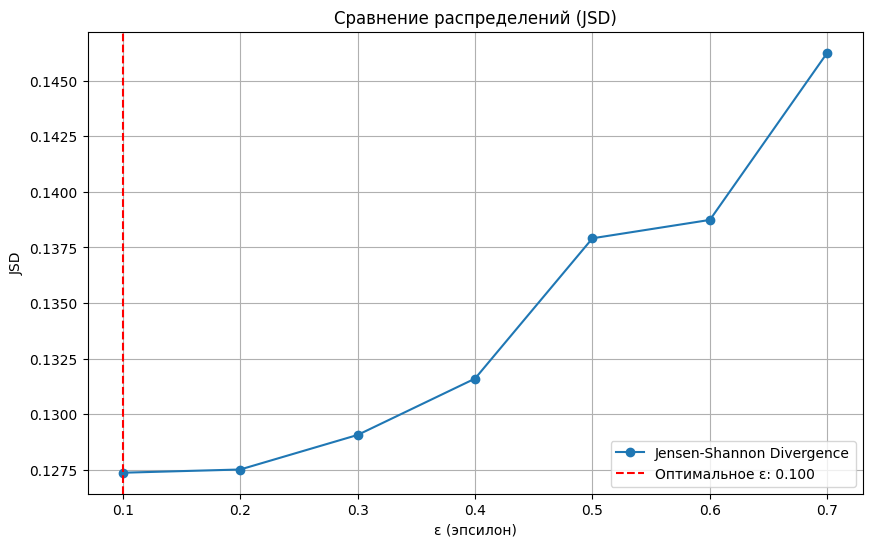

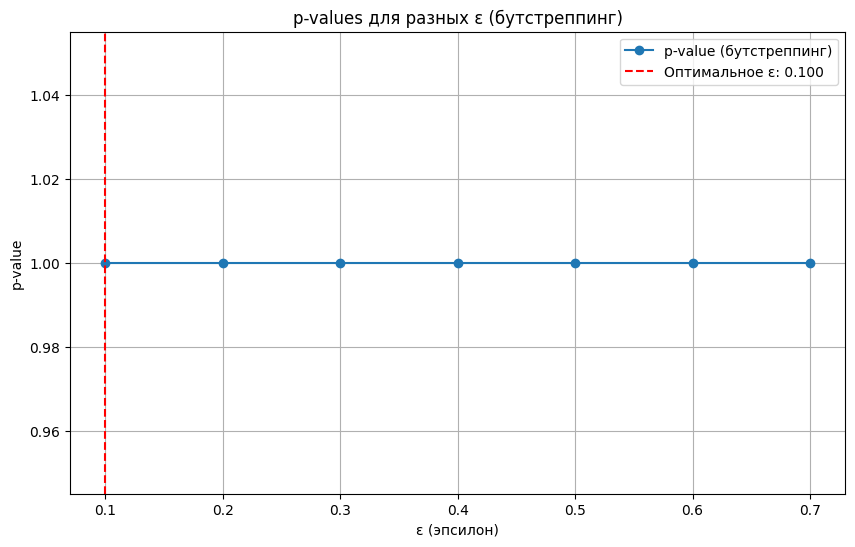

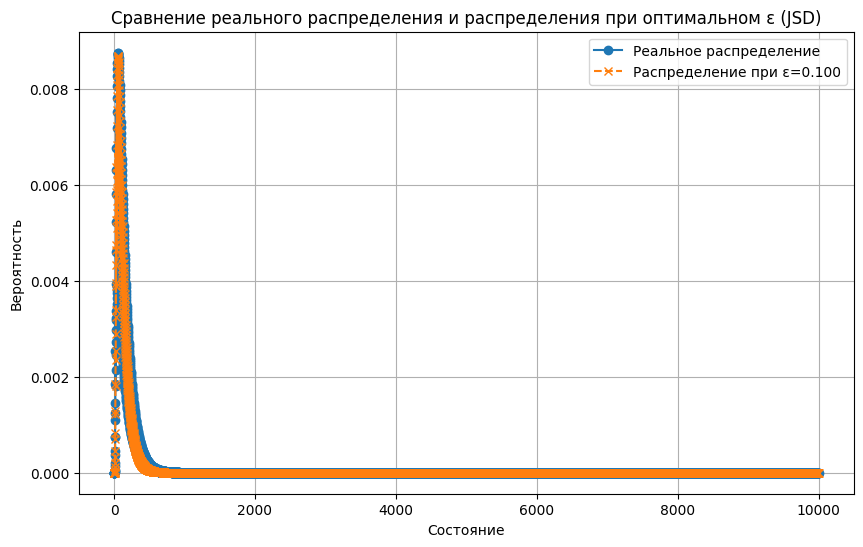

In [17]:
from scipy.spatial.distance import jensenshannon

js_distances = []
p_values = []
for prob in pmf_epsilon:
    js_distance = jensenshannon(prob_real, prob)
    js_distances.append(js_distance)
    p_value = bootstrap_jsd(prob_real, prob)
    p_values.append(p_value)
optimal_epsilon_js = epsilon_vals[np.argmin(js_distances)]
optimal_prob_js = pmf_epsilon[np.argmin(js_distances)]
print(f"Оптимальное ε (JSD): {optimal_epsilon_js:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, js_distances, marker='o', label='Jensen-Shannon Divergence')
plt.axvline(optimal_epsilon_js, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_js:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('JSD')
plt.title('Сравнение распределений (JSD)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, p_values, marker='o', label='p-value (бутстреппинг)')
plt.axvline(optimal_epsilon_js, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_js:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('p-values для разных ε (бутстреппинг)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(prob_real, label='Реальное распределение', linestyle='-', marker='o')
plt.plot(optimal_prob_js, label=f'Распределение при ε={optimal_epsilon_js:.3f}', linestyle='--', marker='x')
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε (JSD)')
plt.legend()
plt.grid()
plt.show()

AD-тест

C:\Users\Илья\AppData\Local\Temp\ipykernel_8232\2036576675.py:3: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_stat, critical_values, p_value = anderson_ksamp([prob_real, prob])


Оптимальное ε: 0.100


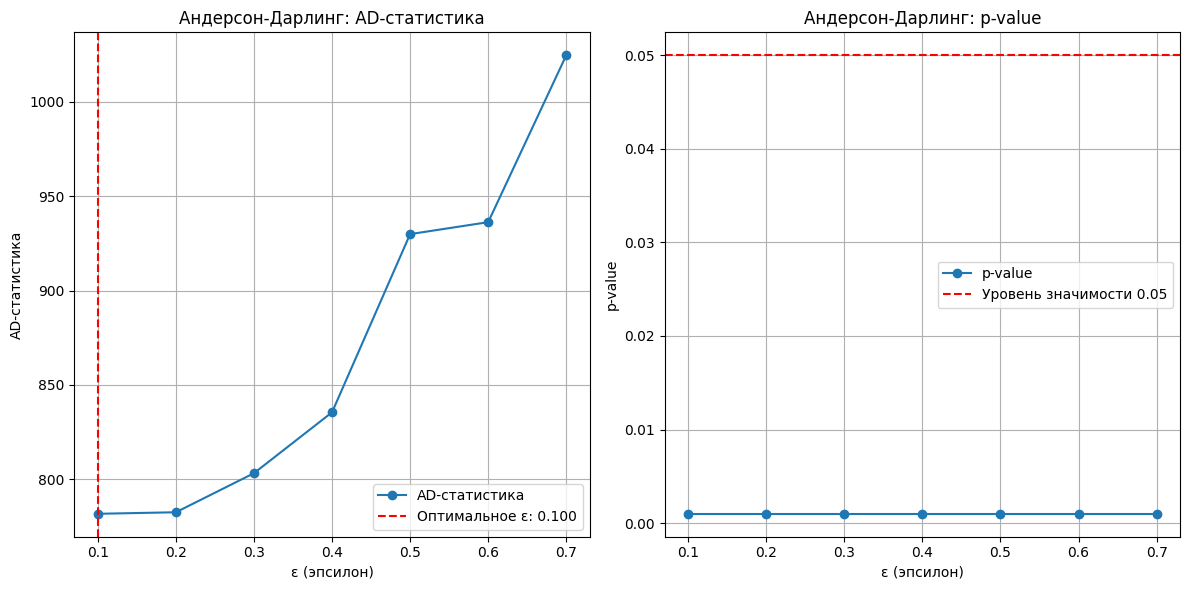

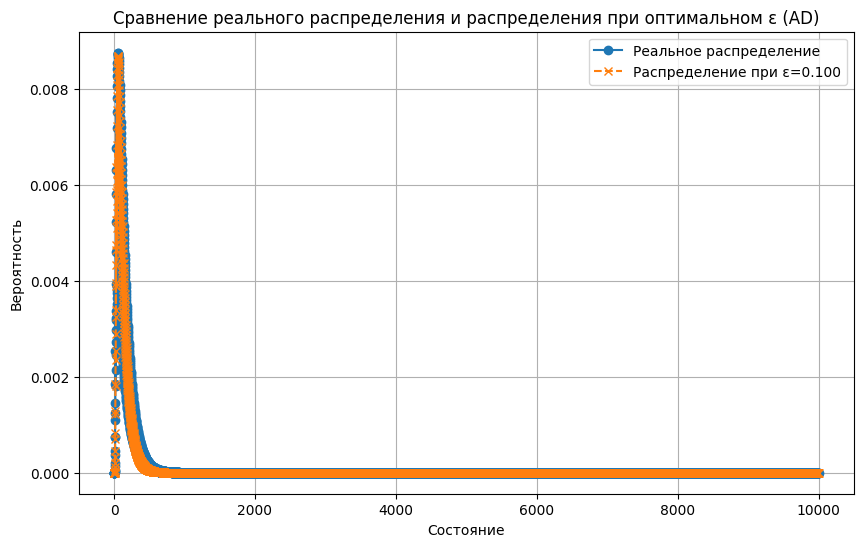

In [20]:
ad_results = []
for prob in pmf_epsilon:
    ad_stat, critical_values, p_value = anderson_ksamp([prob_real, prob])
    ad_results.append((ad_stat, p_value))

ad_stats = [res[0] for res in ad_results]
ad_p_values = [res[1] for res in ad_results]

optimal_epsilon_ad = epsilon_vals[np.argmin(ad_stats)]
optimal_prob_ad = pmf_epsilon[np.argmin(ad_stats)]

print(f"Оптимальное ε: {optimal_epsilon_ad:.3f}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epsilon_vals, ad_stats, marker='o', label='AD-статистика')
plt.axvline(optimal_epsilon_ad, color='red', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon_ad:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('AD-статистика')
plt.title('Андерсон-Дарлинг: AD-статистика')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epsilon_vals, ad_p_values, marker='o', label='p-value')
plt.axhline(y=0.05, color='red', linestyle='--', label='Уровень значимости 0.05')
plt.xlabel('ε (эпсилон)')
plt.ylabel('p-value')
plt.title('Андерсон-Дарлинг: p-value')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(prob_real, label='Реальное распределение', linestyle='-', marker='o')
plt.plot(optimal_prob_ad, label=f'Распределение при ε={optimal_epsilon_ad:.3f}', linestyle='--', marker='x')
plt.xlabel('Состояние')
plt.ylabel('Вероятность')
plt.title('Сравнение реального распределения и распределения при оптимальном ε (AD)')
plt.legend()
plt.grid()
plt.show()